# Audio resampling in Python

Original notebook by Joachim Thiemann, 11.8.2016, joachim.thiemann@uni-oldenburg.de, see: https://signalsprocessed.blogspot.com/2016/08/audio-resampling-in-python.html?m=0

Now maintained by Jonas Haag at https://github.com/jonashaag/audio-resampling-in-python, with more libraries.

---

One of the most basic tasks in audio processing anyone would need to do is resampling audio files; seems like the data you want to process is never sampled in the rate you want. 44.1k? 16k? 8k? Those are the common ones; there are some really odd ones out there.

Resampling is actually quite hard to get right. You need to properly choose your antialias filters, and write a interpolation/decimation procedure that won't introduce too much noise. There have been books written on this topic. For the most part, there is no single univeral way to to this right, since context matters.

For a more detailed discussion on sample rate conversion see the aptly named "Digital Audio Resampling Homepage" [https://ccrma.stanford.edu/~jos/resample/]. Then look at [http://src.infinitewave.ca/] for a super informative comparison of a ton of resampling implementations. No seriously, go there. (It inspired me to compare the methods below using a sine sweep.)

Now for a comparison with pretty pictures.

## Setup

In [ ]:
!apt-get -qq install -y libsamplerate0-dev
!pip install -qU samplerate scipy resampy torchaudio julius soxr nnresample
!pip install -qU git+https://github.com/gregorias/samplerate.git
!pip install -qU git+https://github.com/danpovey/filtering.git

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import samplerate  # https://pypi.org/project/samplerate/
import scikits.samplerate  # https://github.com/gregorias/samplerate
import scipy.signal
import resampy

import lilfilter  # https://github.com/danpovey/filtering
import julius  # https://github.com/adefossez/julius
import soxr  # https://github.com/dofuuz/python-soxr
import nnresample  # https://github.com/jthiem/nnresample

import torch, torchaudio

In [2]:
import sys
!{sys.executable} -m pip freeze | grep -E "samplerate|scipy|resampy|torchaudio|lilfilter|julius|scikits|soxr|nnresample"

julius==0.2.4
lilfilter @ git+https://github.com/danpovey/filtering.git@da8edda4c8fb651eb9dbd7b25f7fc8f18b2cc144
nnresample==0.2.4.1
resampy==0.2.2
samplerate==0.1.0
scikits.samplerate @ git+https://github.com/gregorias/samplerate.git@f3f7b76bf6b4c26612777852e3c9315de45bc45b
scipy==1.7.0
soxr==0.2.4
torchaudio==0.9.0


---

## Downsampling a sweep

A common task is to convert between the CD sampling rate of 44.1 kHz, and the multiples of 8kHz that originated from the telekon industry.  In particular, 48kHz.  (Supposedly the rate of 44.1k was chosen in part _because_ is was difficult to convert to 48 kHz; but it is also connected to NTSC timing).  So let's have a sweep sampled at 48 kHz.

In [3]:
VMIN = -150

P = 48000
Q = 44100

offset = 2000
instfreq = np.exp(np.linspace(np.log(offset+100), np.log(offset+23900), 96000))-offset
deltaphase = 2*np.pi*instfreq/P
cphase = np.cumsum(deltaphase)
sig = np.sin(cphase, dtype=np.float64)

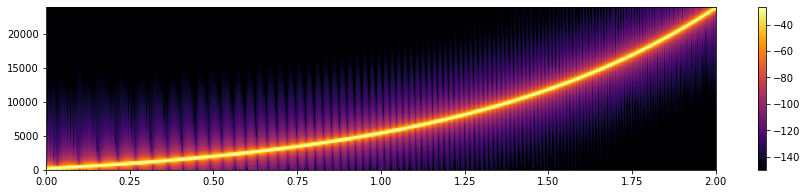

In [4]:
plt.figure(figsize=(15,3))
plt.specgram(sig, scale='dB', Fs=P, vmin=VMIN, cmap='inferno')
plt.colorbar()
_=plt.axis((0,2,0,P/2))

Now convert it to 44.1 kHz using the different libraries, and plot the spectrograms.

### samplerate

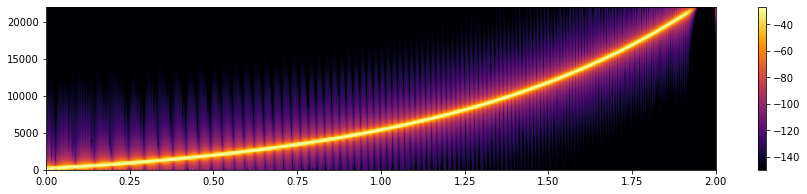

In [5]:
plt.figure(figsize=(15,3))
plt.specgram(samplerate.resample(sig, Q/P, 'sinc_best'),
             scale='dB', Fs=Q, vmin=VMIN, cmap='inferno')
plt.colorbar()
_=plt.axis((0,2,0,Q/2))

### scikits-samplerate

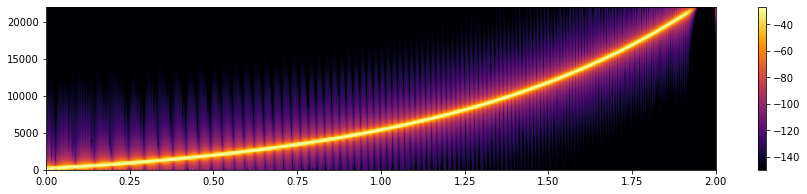

In [6]:
plt.figure(figsize=(15,3))
plt.specgram(scikits.samplerate.resample(sig, Q/P, 'sinc_best'),
             scale='dB', Fs=Q, vmin=VMIN, cmap='inferno')
plt.colorbar()
_=plt.axis((0,2,0,Q/2))

### scipy.signal.resample

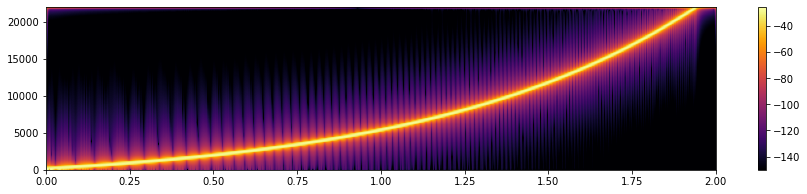

In [7]:
plt.figure(figsize=(15,3))
plt.specgram(scipy.signal.resample(sig, int(len(sig)*Q/P)),
             scale='dB', Fs=Q, vmin=VMIN, cmap='inferno')
plt.colorbar()
_=plt.axis((0,2,0,Q/2))

### resampy (librosa)

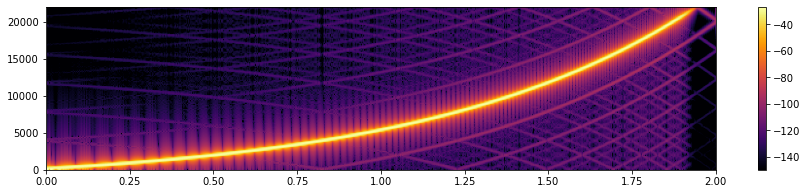

In [8]:
plt.figure(figsize=(15,3))
plt.specgram(resampy.resample(sig, P, Q, filter="kaiser_best"),
             scale='dB', Fs=Q, vmin=VMIN, cmap='inferno')
plt.colorbar()
_=plt.axis((0,2,0,Q/2))

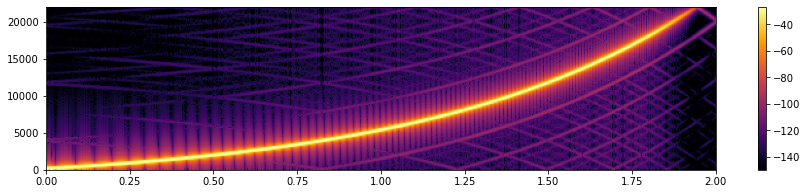

In [9]:
plt.figure(figsize=(15,3))
plt.specgram(resampy.resample(sig, P, Q, filter="kaiser_fast"),
             scale='dB', Fs=Q, vmin=VMIN, cmap='inferno')
plt.colorbar()
_=plt.axis((0,2,0,Q/2))

### torchaudio

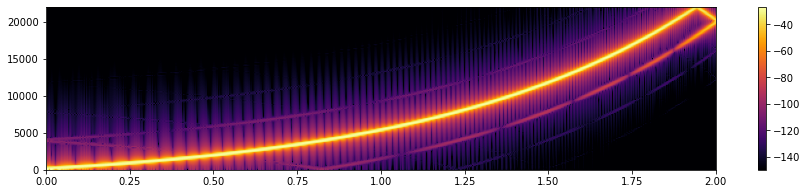

In [10]:
plt.figure(figsize=(15,3))
plt.specgram(torchaudio.transforms.Resample(P, Q, dtype=torch.float64)(torch.from_numpy(sig)).numpy(),
             scale='dB', Fs=Q, vmin=VMIN, cmap='inferno')
plt.colorbar()
_=plt.axis((0,2,0,Q/2))

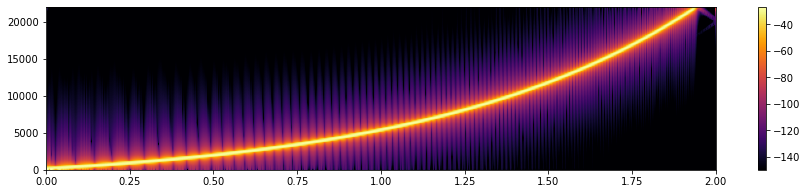

In [11]:
plt.figure(figsize=(15,3))
plt.specgram(torchaudio.transforms.Resample(P, Q, lowpass_filter_width=150, dtype=torch.float64)(torch.from_numpy(sig)).numpy(),
             scale='dB', Fs=Q, vmin=VMIN, cmap='inferno')
plt.colorbar()
_=plt.axis((0,2,0,Q/2))

### lilfilter

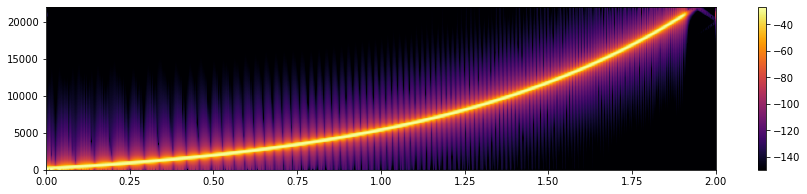

In [12]:
plt.figure(figsize=(15,3))
plt.specgram(lilfilter.resample(sig.reshape([1, -1]), P, Q).reshape([-1]),
             scale='dB', Fs=Q, vmin=VMIN, cmap='inferno')
plt.colorbar()
_=plt.axis((0,2,0,Q/2))

### julius

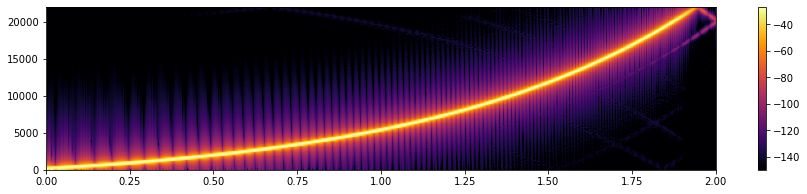

In [13]:
plt.figure(figsize=(15,3))
plt.specgram(julius.resample_frac(torch.from_numpy(sig), P, Q).numpy(),
             scale='dB', Fs=Q, vmin=VMIN, cmap='inferno')
plt.colorbar()
_=plt.axis((0,2,0,Q/2))

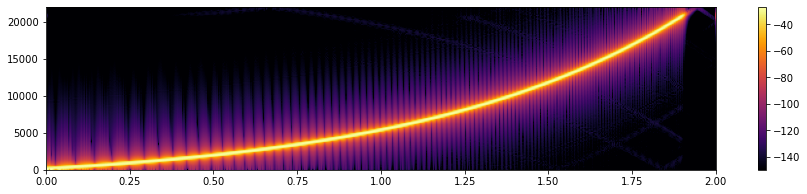

In [14]:
plt.figure(figsize=(15,3))
plt.specgram(julius.resample_frac(torch.from_numpy(sig), P, Q, zeros=150).numpy(),
             scale='dB', Fs=Q, vmin=VMIN, cmap='inferno')
plt.colorbar()
_=plt.axis((0,2,0,Q/2))

### soxr

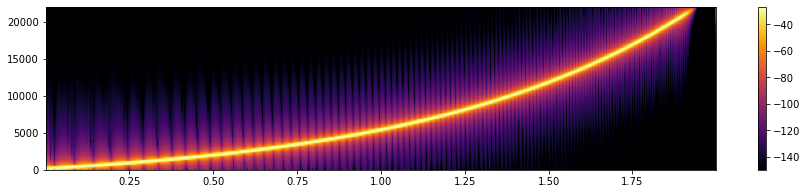

In [15]:
plt.figure(figsize=(15,3))
plt.specgram(soxr.resample(sig, P, Q),
             scale='dB', Fs=Q, vmin=VMIN, cmap='inferno')
plt.colorbar()

### nnresample

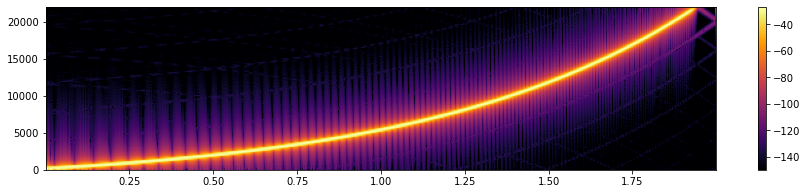

In [16]:
plt.figure(figsize=(15,3))
plt.specgram(nnresample.resample(sig, Q, P),
             scale='dB', Fs=Q, vmin=VMIN, cmap='inferno')
plt.colorbar()

---

## Upsampling a sweep

In [17]:
P = 48000
Q = 44100
P,Q = Q,P # <== upsampling

offset = 2000
instfreq = np.exp(np.linspace(np.log(offset+100), np.log(offset+23900), 96000))-offset
deltaphase = 2*np.pi*instfreq/P
cphase = np.cumsum(deltaphase)
sig = np.sin(cphase)

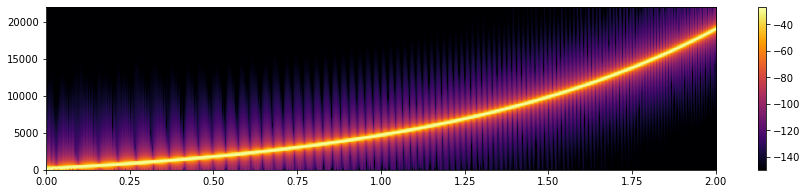

In [18]:
plt.figure(figsize=(15,3))
plt.specgram(sig, scale='dB', Fs=P, vmin=VMIN, cmap='inferno')
plt.colorbar()
_=plt.axis((0,2,0,P/2))

### scikits-resamplerate (libsrc)

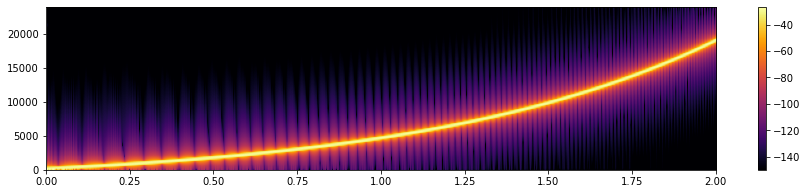

In [19]:
plt.figure(figsize=(15,3))
plt.specgram(scikits.samplerate.resample(sig, Q/P, 'sinc_best'),
             scale='dB', Fs=Q, vmin=VMIN, cmap='inferno')
plt.colorbar()
_=plt.axis((0,2,0,Q/2))

### scipy.signal.resample

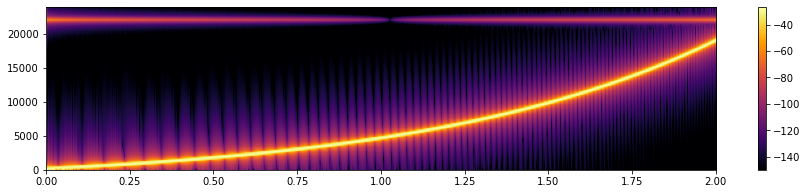

In [20]:
plt.figure(figsize=(15,3))
plt.specgram(scipy.signal.resample(sig, int(len(sig)*Q/P)),
             scale='dB', Fs=Q, vmin=VMIN, cmap='inferno')
plt.colorbar()
_=plt.axis((0,2,0,Q/2))

### torchaudio

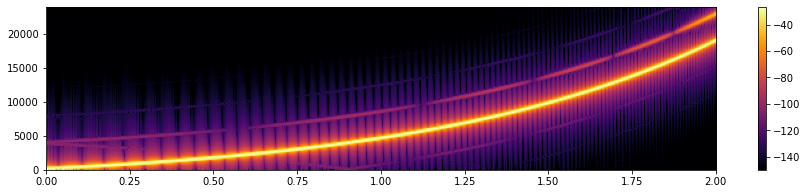

In [21]:
plt.figure(figsize=(15,3))
plt.specgram(torchaudio.transforms.Resample(P, Q, dtype=torch.float64)(torch.from_numpy(sig)).numpy(),
             scale='dB', Fs=Q, vmin=VMIN, cmap='inferno')
plt.colorbar()
_=plt.axis((0,2,0,Q/2))

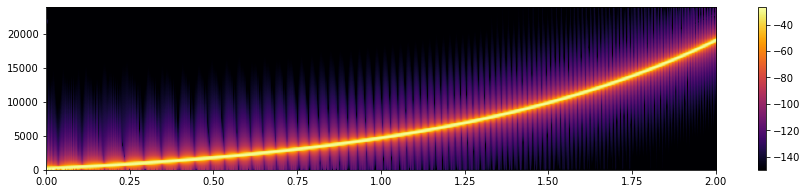

In [22]:
plt.figure(figsize=(15,3))
plt.specgram(torchaudio.transforms.Resample(P, Q, lowpass_filter_width=150, dtype=torch.float64)(torch.from_numpy(sig)).numpy(),
             scale='dB', Fs=Q, vmin=VMIN, cmap='inferno')
plt.colorbar()
_=plt.axis((0,2,0,Q/2))

### resampy (librosa)

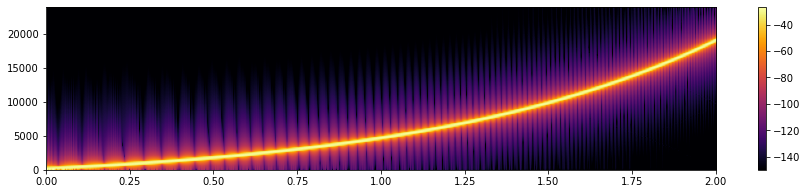

In [23]:
plt.figure(figsize=(15,3))
plt.specgram(resampy.resample(sig, P, Q, filter="kaiser_best"),
             scale='dB', Fs=Q, vmin=VMIN, cmap='inferno')
plt.colorbar()
_=plt.axis((0,2,0,Q/2))

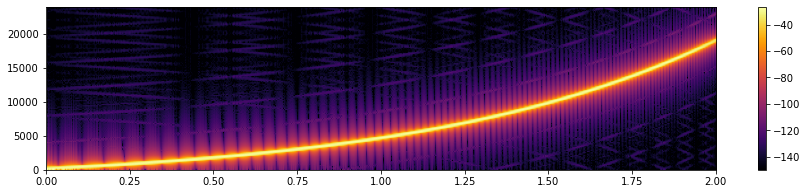

In [24]:
plt.figure(figsize=(15,3))
plt.specgram(resampy.resample(sig, P, Q, filter="kaiser_fast"),
             scale='dB', Fs=Q, vmin=VMIN, cmap='inferno')
plt.colorbar()
_=plt.axis((0,2,0,Q/2))

### lilfilter

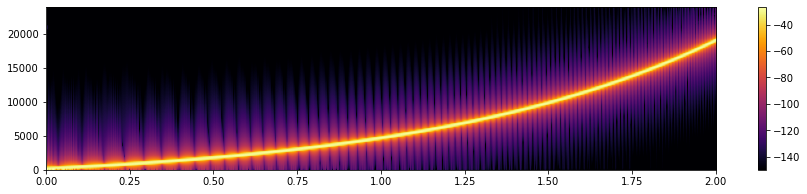

In [25]:
plt.figure(figsize=(15,3))
plt.specgram(lilfilter.resample(sig.reshape([1, -1]), P, Q).reshape([-1]),
             scale='dB', Fs=Q, vmin=VMIN, cmap='inferno')
plt.colorbar()
_=plt.axis((0,2,0,Q/2))

### julius

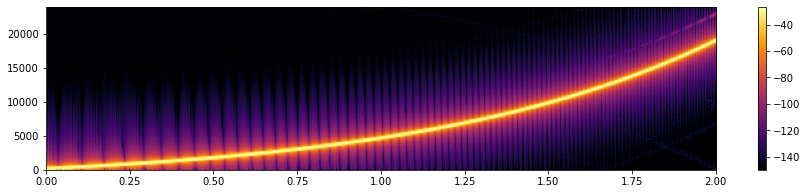

In [26]:
plt.figure(figsize=(15,3))
plt.specgram(julius.resample_frac(torch.from_numpy(sig), P, Q).numpy(),
             scale='dB', Fs=Q, vmin=VMIN, cmap='inferno')
plt.colorbar()
_=plt.axis((0,2,0,Q/2))

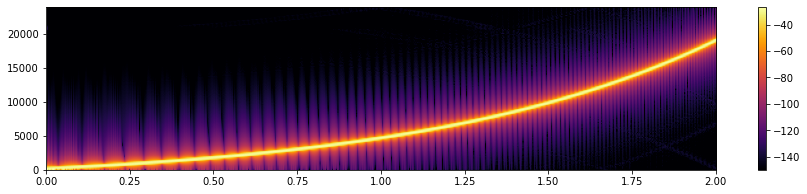

In [27]:
plt.figure(figsize=(15,3))
plt.specgram(julius.resample_frac(torch.from_numpy(sig), P, Q, zeros=150).numpy(),
             scale='dB', Fs=Q, vmin=VMIN, cmap='inferno')
plt.colorbar()
_=plt.axis((0,2,0,Q/2))

### soxr

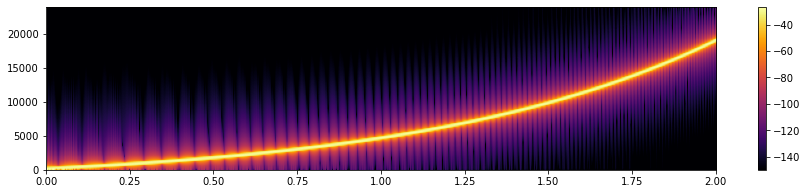

In [28]:
plt.figure(figsize=(15,3))
plt.specgram(soxr.resample(sig, P, Q),
             scale='dB', Fs=Q, vmin=VMIN, cmap='inferno')
plt.colorbar()
_=plt.axis((0,2,0,Q/2))

### nnresample

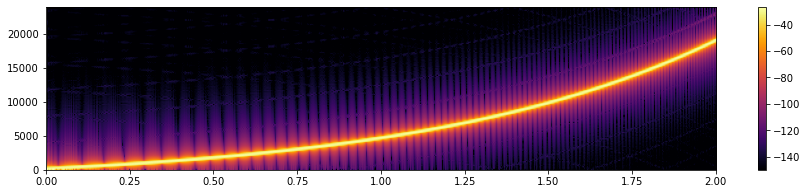

In [29]:
plt.figure(figsize=(15,3))
plt.specgram(nnresample.resample(sig, Q, P),
             scale='dB', Fs=Q, vmin=VMIN, cmap='inferno')
plt.colorbar()
_=plt.axis((0,2,0,Q/2))

---

## Upsampling an impulse

A way to examine the antialias filter is to upsample an impulse.  Here, note a frustrating aspect of all these differing libraries: the interface is completely different beween all of them; and to boot, `resampy` and `scikit.resample` give different length outputs for the same upsampling ratio.  This means you can't just switch between them using a `from foo import resample` statement, you'll need a wrapper function if you want to switch freely amongst them (see `librosa` as an example).

In [30]:
P = 48000
Q = 44100

impulse = np.zeros(1000)
impulse[499] = 1

us1 = scikits.samplerate.resample(impulse, P/Q, 'sinc_best')
us11 = samplerate.resample(impulse, P/Q, 'sinc_best')
us2 = scipy.signal.resample(impulse, int(len(impulse)*P/Q))
us3 = resampy.resample(impulse, Q, P, filter="kaiser_best")
us31 = resampy.resample(impulse, Q, P, filter="kaiser_fast")
us4 = torchaudio.transforms.Resample(Q, P, dtype=torch.float64)(torch.from_numpy(impulse)).numpy()
us5 = lilfilter.resample(impulse[None], Q, P).reshape([-1])
us6 = julius.resample_frac(torch.from_numpy(impulse), Q, P).numpy()
us7 = soxr.resample(impulse, Q, P)
us8 = nnresample.resample(impulse, P, Q)

# For some reason, julius + lilfilter results are shifted.
# Align everything to us1
us11 = np.pad(us11, (us1.argmax() - us11.argmax(), 0))
us2 = np.pad(us2, (us1.argmax() - us2.argmax(), 0))
us3 = np.pad(us3, (us1.argmax() - us3.argmax(), 0))
us31 = np.pad(us31, (us1.argmax() - us31.argmax(), 0))
us4 = np.pad(us4, (us1.argmax() - us4.argmax(), 0))
us5 = np.pad(us5, (us1.argmax() - us5.argmax(), 0))
us6 = np.pad(us6, (us1.argmax() - us6.argmax(), 0))
us7 = np.pad(us7, (us1.argmax() - us7.argmax(), 0))
us8 = np.pad(us8, (us1.argmax() - us8.argmax(), 0))

print(us1.shape, us11.shape, us2.shape, us3.shape, us4.shape, us5.shape, us6.shape, us7.shape, us8.shape)

(1087,) (1088,) (1088,) (1088,) (1089,) (960,) (1088,) (1088,) (1089,)


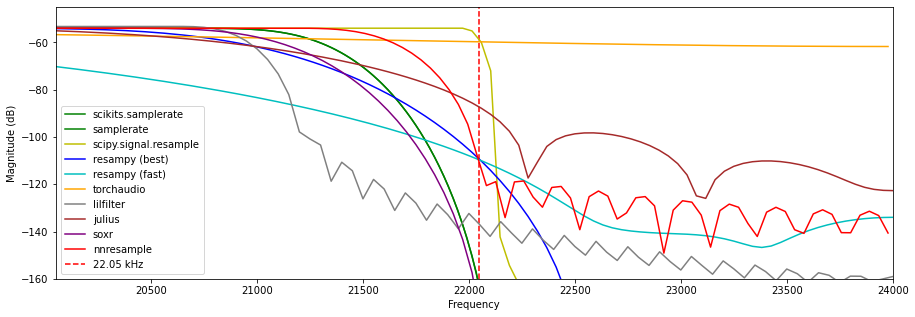

In [31]:
plt.figure(figsize=(15,5))
plt.magnitude_spectrum(us1, c='g', Fs=P, scale='dB', label='scikits.samplerate')
plt.magnitude_spectrum(us11, c='g', Fs=P, scale='dB', label='samplerate')
plt.magnitude_spectrum(us2, c='y', Fs=P, scale='dB', label='scipy.signal.resample')
plt.magnitude_spectrum(us3, c='b', Fs=P, scale='dB', label='resampy (best)')
plt.magnitude_spectrum(us31, c='c', Fs=P, scale='dB', label='resampy (fast)')
plt.magnitude_spectrum(us4, c='orange', Fs=P, scale='dB', label='torchaudio')
plt.magnitude_spectrum(us5, c='grey', Fs=P, scale='dB', label='lilfilter')
plt.magnitude_spectrum(us6, c='brown', Fs=P, scale='dB', label='julius')
plt.magnitude_spectrum(us7, c='purple', Fs=P, scale='dB', label='soxr')
plt.magnitude_spectrum(us8, c='red', Fs=P, scale='dB', label='nnresample')
plt.axis((Q/2 - 2000, P/2, -160, -45))
_=plt.vlines(Q/2, -160, 3, colors='r', linestyles='dashed', label='22.05 kHz')
_=plt.legend(loc='lower left')

What do the impulse responses look like in time domain?

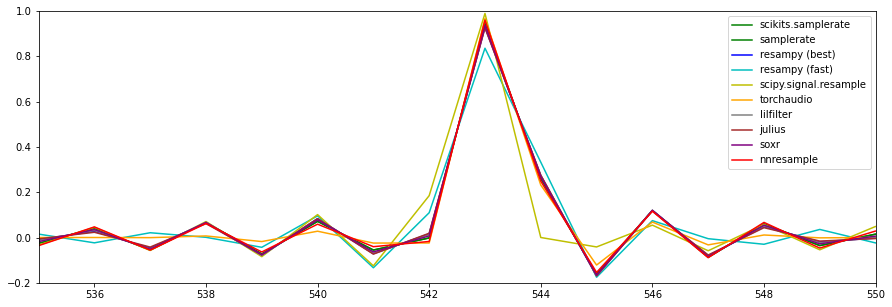

In [32]:
plt.figure(figsize=(15,5))
plt.plot(us1, c='g', label='scikits.samplerate')
plt.plot(us11, c='g', label='samplerate')
plt.plot(us3, c='b', label='resampy (best)')
plt.plot(us31, c='c', label='resampy (fast)')
plt.plot(us2, c='y', label='scipy.signal.resample')
plt.plot(us4, c='orange', label='torchaudio')
plt.plot(us5, c='gray', label='lilfilter')
plt.plot(us6, c='brown', label='julius')
plt.plot(us7, c='purple', label='soxr')
plt.plot(us8, c='red', label='nnresample')
plt.axis((535, 550, -0.2, 1))
_=plt.legend()

<ipython-input-33-3c6f77b51af4>:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(10*np.log10(np.square(us1)), c='g', label='scikits.samplerate')
<ipython-input-33-3c6f77b51af4>:3: RuntimeWarning: divide by zero encountered in log10
  plt.plot(10*np.log10(np.square(us11)), c='g', label='samplerate')
<ipython-input-33-3c6f77b51af4>:5: RuntimeWarning: divide by zero encountered in log10
  plt.plot(10*np.log10(np.square(us3)), c='b', label='resampy (best)')
<ipython-input-33-3c6f77b51af4>:6: RuntimeWarning: divide by zero encountered in log10
  plt.plot(10*np.log10(np.square(us31)), c='c', label='resampy (fast)')
<ipython-input-33-3c6f77b51af4>:7: RuntimeWarning: divide by zero encountered in log10
  plt.plot(10*np.log10(np.square(us4)), c='orange', label='torchaudio')
<ipython-input-33-3c6f77b51af4>:8: RuntimeWarning: divide by zero encountered in log10
  plt.plot(10*np.log10(np.square(us5)), c='gray', label='lilfilter')
<ipython-input-33-3c6f77b51af4>:9: RuntimeWarning: 

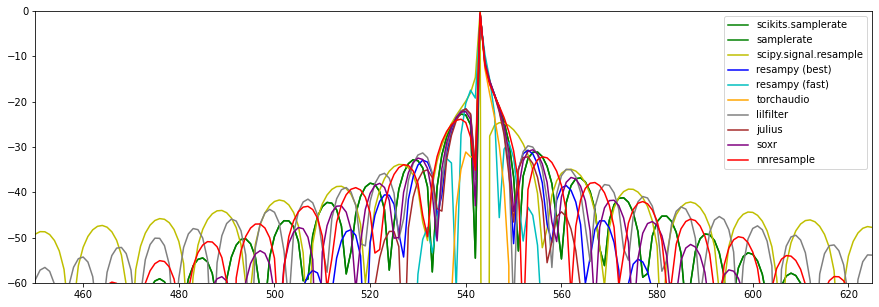

In [33]:
plt.figure(figsize=(15,5))
plt.plot(10*np.log10(np.square(us1)), c='g', label='scikits.samplerate')
plt.plot(10*np.log10(np.square(us11)), c='g', label='samplerate')
plt.plot(10*np.log10(np.square(us2)), c='y', label='scipy.signal.resample')
plt.plot(10*np.log10(np.square(us3)), c='b', label='resampy (best)')
plt.plot(10*np.log10(np.square(us31)), c='c', label='resampy (fast)')
plt.plot(10*np.log10(np.square(us4)), c='orange', label='torchaudio')
plt.plot(10*np.log10(np.square(us5)), c='gray', label='lilfilter')
plt.plot(10*np.log10(np.square(us6)), c='brown', label='julius')
plt.plot(10*np.log10(np.square(us7)), c='purple', label='soxr')
plt.plot(10*np.log10(np.square(us8)), c='red', label='nnresample')
plt.axis((450, 625, -60, 0))
_=plt.legend()

---

## Speed comparison

In [34]:
%timeit scikits.samplerate.resample(sig, Q/P, 'sinc_best')

84.6 ms ± 2.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [35]:
%timeit samplerate.resample(sig, Q/P, 'sinc_best')

85.7 ms ± 7.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [36]:
%timeit scipy.signal.resample(sig, int(len(sig)*Q/P))

1.94 ms ± 218 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [37]:
%timeit resampy.resample(sig, P, Q, filter="kaiser_best")
%timeit resampy.resample(sig, P, Q, filter="kaiser_fast")

61.6 ms ± 2.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
12.7 ms ± 740 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [38]:
%timeit soxr.resample(sig, P, Q)

1.23 ms ± 61.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [39]:
%timeit nnresample.resample(sig, Q, P)

19.2 ms ± 773 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [40]:
# NOTE: All Torch benchmarks are done on a single CPU, not GPU!
sig_torch = torch.from_numpy(sig)[None]

In [41]:
resampler = torchaudio.transforms.Resample(P, Q, dtype=torch.float64)
%timeit resampler(sig_torch)
%timeit torchaudio.functional.resample(sig_torch, P, Q)

977 µs ± 37.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
10.7 ms ± 258 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [42]:
%timeit lilfilter.resample(sig_torch, P, Q)

5.02 ms ± 172 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [43]:
%timeit julius.resample_frac(sig_torch, P, Q)

12.5 ms ± 633 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
